In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_pmid = '20142476'
savir_df = raw_kin_df[raw_kin_df.pmid_or_doi == savir_pmid]
nonsavir_df = raw_kin_df[raw_kin_df.pmid_or_doi != savir_pmid]

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

395 total WT RuBisCOs
303 total unique species
207 RuBisCOs with all core kinetic data measured


In [4]:
cols = ['S', 'vC', 'KC', 'KO', 'kon_C', 'kon_O']
all_F1 = raw_kin_df[raw_kin_df.isoform == '1']
r_cis = {}

for c in cols:
    print('vO vs %s' % c)
    vOs = raw_kin_df.vO
    vals = raw_kin_df[c]
    log_vOs = np.log(vOs)
    log_vals = np.log(vals)

    r, p = power_laws.log_pearsonr(log_vOs, log_vals)
    print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
    print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(log_vOs, log_vals))

    exps, pres, rs = power_laws.bootstrap_power_law_odr(vOs, vals)
    conf_range = [2.5, 97.5]
    pre_interval = np.percentile(pres, conf_range)
    exp_interval = np.percentile(exps, conf_range)
    rs_interval = np.percentile(rs, conf_range)
    
    r_cis[c] = rs_interval
    print(exp_interval)
    print(pre_interval)
    print(rs_interval)
    print()

vO vs S
Log-scale linear regression R = 0.38, P = 1.5e-08
Spearman rank correlation R = -0.19, P = 0.0054
[-0.12521672  2.54986114]
[79.66574769 97.85237709]
[0.02108675 0.62230131]

vO vs vC
Log-scale linear regression R = 0.45, P = 1.1e-11
Spearman rank correlation R = 0.38, P = 1.6e-08
[0.34346976 1.10396953]
[3.2382497  3.65691607]
[0.24996125 0.59200678]

vO vs KC
Log-scale linear regression R = -0.39, P = 6.6e-09
Spearman rank correlation R = -0.32, P = 3e-06
[-4.15714453 -1.14277232]
[15.43167916 20.91152703]
[0.23219754 0.52616209]

vO vs KO
Log-scale linear regression R = 0.48, P = 3.5e-13
Spearman rank correlation R = 0.24, P = 0.00045
[0.29045822 1.61909023]
[459.87860065 558.08909424]
[0.1035809  0.70958257]

vO vs kon_C
Log-scale linear regression R = 0.67, P = 1.1e-28
Spearman rank correlation R = 0.56, P = 1.6e-18
[1.14313908 2.06133132]
[0.1657125  0.19758072]
[0.55673721 0.76648767]

vO vs kon_O
Log-scale linear regression R = 0.42, P = 1.9e-10
Spearman rank correlatio

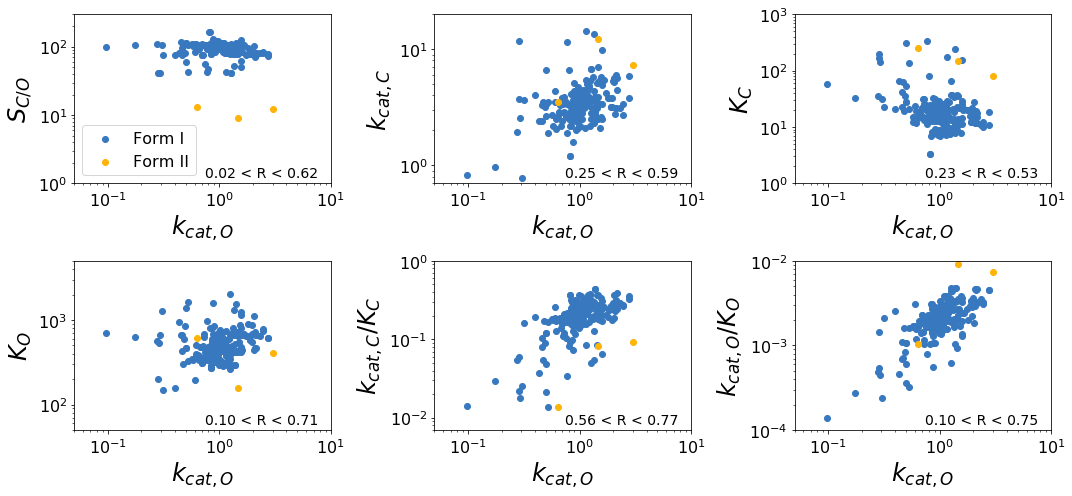

In [5]:
# Description of the data set
figure = plt.figure(figsize=(15,7))

cols = ['S', 'vC', 'KC', 'KO', 'kon_C', 'kon_O']
titles = {'S': '$S_{C/O}$',
          'vC': '$k_{cat,C}$',
          'KC': '$K_C$',
          'vO': '$k_{cat,O}$',
          'KO': '$K_O$',
          'kon_C': '$k_{cat,C}/K_C$',
          'kon_O': '$k_{cat,O}/K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless',
         'vC': '$s^{-1}$',
         'KC': '$\mu M$',
         'vO': '$s^{-1}$',
         'KO': '$\mu M$',
         'kon_C': '$\mu M^{-1} s^{-1}$',
         'kon_O': '$\mu M^{-1} s^{-1}$',
         'KRuBP': '$\mu M$'}
lim = {'S': (1, 300),
       'vC': (7e-1, 20),
       'vO':(1e-2, 20),
       'KC': (1, 1e3),
       'KO': (50, 5e3),
       'kon_C': (7e-3, 1e0),
       'kon_O': (1e-4, 1e-2),
       'KRuBP': (0.1, 1.5e2)}
groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

nsub = len(cols)
pal = seaborn.color_palette('Set3')

for i, c in enumerate(cols):
    mask = raw_kin_df[c].notnull()
    vals = raw_kin_df[mask][c]
    
    ax = plt.subplot(2, nsub/2.0, i+1)
    plt.xscale('log')
    plt.yscale('log')

    for j, (group, gdf) in enumerate(raw_kin_df.groupby('isoform')):
        if group not in ['1', '2']:
            continue
        
        color = named_colors[j]
        label = 'Form %s' % groups[group]
        
        mask = gdf[c].notnull() & gdf.vO.notnull()
        plt.scatter(gdf[mask].vO, gdf[mask][c], color=color, label=label)
        
        if group == '1':
            corr = '%.2f < R < %.2f' % (r_cis[c][0], r_cis[c][1])
            plt.text(0.95, 0.1, corr, transform=ax.transAxes,
                     fontsize=14, ha='right', va='top')
    
        if c == 'S':
            plt.legend(loc=3, frameon=True, fontsize=16)
    
    sigma_star = np.nanstd(np.log(raw_kin_df[c]))
    nvals = raw_kin_df[c].notnull().sum()
    ylabel = titles[c]

    plt.ylim(*lim[c])
    plt.xlim(0.05, 10)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(ylabel, fontsize=24)
    plt.xlabel('$k_{cat,O}$', fontsize=24, ha='center')
    
    
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('figS7/figS7_kcatO_corr.svg')
plt.savefig('figS7/figS7_kcatO_corr.png', dpi=400)

plt.show()